In [1]:
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import stateinterpreter
from stateinterpreter.MD import Loader
from stateinterpreter.classifier import Classifier
from stateinterpreter.plot import plot_cvpath, plot_states, plot_combination_cvs_relevant_features
from importlib import reload
reload(stateinterpreter.classifier)
reload(stateinterpreter.plot)

<module 'stateinterpreter.plot' from '../../stateinterpreter/plot.py'>

In [2]:
import re
def get_residue(s):
    m = re.search(r'\d+$', s)
    return m.group() if m else None

def _get_angle_groups(angle_names):
    groups = []
    for s in angle_names:
        groups.append(get_residue(s))
    return np.array(groups, dtype=int)

In [3]:
BPTI_data_path = '../../../data/md_datasets/BPTI-unbiased/'
colvar_file = BPTI_data_path + 'COLVAR'
traj_dict = {
        'trajectory' : BPTI_data_path+'all_trj_10ns.trr',
        'topology' : BPTI_data_path+'bpti-protein.pdb'
    }
desc_path = '../../../data/md_datasets/BPTI-unbiased/descritpors.pkl'
descriptors = pd.read_pickle(desc_path)
# Compute descriptors from Trajectory
data = Loader(colvar_file, descriptors=descriptors, kbt=2.5)
data.load_trajectory(traj_dict, descriptors=False)

In [4]:
cv_list = ['tica1', 'tica2']
bounds = [(-1,1), (-1,1)]
data.identify_states(cv_list, bounds, bw_method=0.3, fes_cutoff=2.5)
df = data.collect_data()

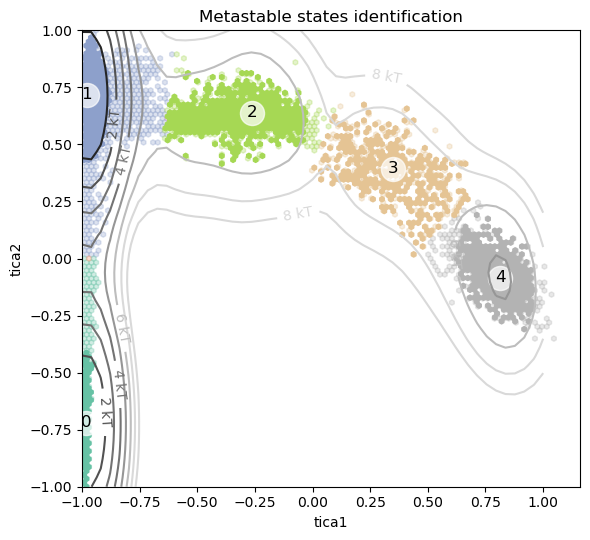

In [5]:
plot_states(data, fes_isolines=True)

In [6]:
for idx in range(data.n_basins):
    l = len(data.basins.loc[ (data.basins['basin'] == idx) & (data.basins['selection'] == True)])
    print(f"Basin {idx} -> {l} configurations.")

Basin 0 -> 26227 configurations.
Basin 1 -> 71427 configurations.
Basin 2 -> 1228 configurations.
Basin 3 -> 416 configurations.
Basin 4 -> 861 configurations.


In [7]:
select_feat = 'sin_|cos_'
sample = data.sample(400, regex_filter = select_feat)

In [8]:
groups = _get_angle_groups(sample.features)
regularizers = np.geomspace(0.1, 1, 12)
dset = sample.train_test_dataset()
classifier = Classifier(dset, sample.features)
classifier.compute(regularizers, max_iter= 100000, groups=groups)

Group Lasso: 100%|██████████| 12/12 [00:31<00:00,  2.62s/it]


In [9]:
np.unique(groups)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57])

(-1.0, 0.0)

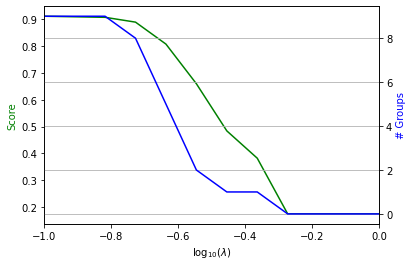

In [10]:
num_groups = []
for reg in regularizers:
    selected = classifier._get_selected(reg)
    unique_idxs = set()
    for state in selected:
        for data in state:
            unique_idxs.add(data[0])
    num_groups.append(len(unique_idxs))

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax2.grid()
ax2.plot(np.log10(regularizers), num_groups, 'b-')
ax1.plot(np.log10(regularizers), classifier._crossval, 'g-')
#ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

ax1.set_xlabel(r"$\log_{10}(\lambda)$")
ax1.set_ylabel('Score', color='g')
ax2.set_ylabel('# Groups', color='b')
ax1.set_xlim(np.log10(regularizers)[0],np.log10(regularizers)[-1])

State 0:
	 33.504% | 38
	 33.164% | 42
	 13.453% | 39
	 5.336%  | 10
	 5.332%  | 36
	 3.796%  | 14
	 2.402%  | 35
	 2.175%  | 9
	 0.838%  | 6
State 1:
	 61.911% | 42
	 15.206% | 39
	 6.477%  | 38
	 5.773%  | 36
	 4.41%   | 14
	 3.109%  | 6
	 1.386%  | 10
	 1.026%  | 35
	 0.703%  | 9
State 2:
	 26.74%  | 42
	 22.558% | 36
	 17.064% | 9
	 9.607%  | 10
	 8.864%  | 6
	 8.111%  | 14
	 3.169%  | 38
	 2.847%  | 39
	 1.041%  | 35
State 3:
	 40.147% | 42
	 20.421% | 36
	 11.637% | 9
	 9.055%  | 6
	 5.753%  | 39
	 3.856%  | 10
	 3.649%  | 38
	 3.581%  | 35
	 1.901%  | 14
State 4:
	 28.994% | 36
	 24.137% | 42
	 13.402% | 14
	 9.644%  | 38
	 7.606%  | 39
	 4.178%  | 35
	 4.17%   | 10
	 4.04%   | 6
	 3.83%   | 9


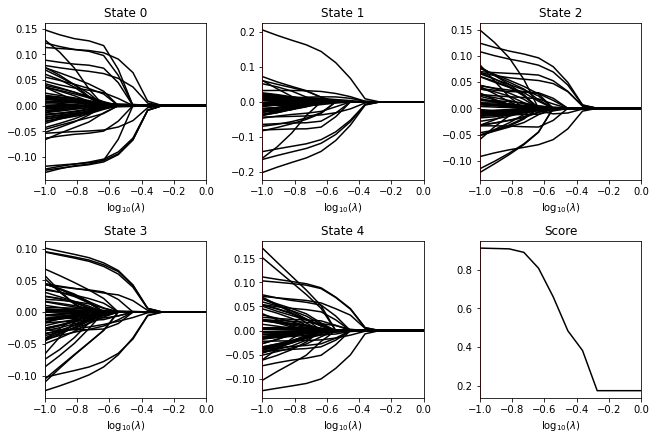

In [11]:
reg = 10**(-1)
plot_cvpath(classifier, reg);
classifier.print_selected(reg)

In [11]:
regularizers = np.geomspace(0.1, 1, 12)
pruned_classifier = classifier.get_pruned(reg)
pruned_classifier.compute(regularizers, max_iter= 10000, quadratic_kernel=False)

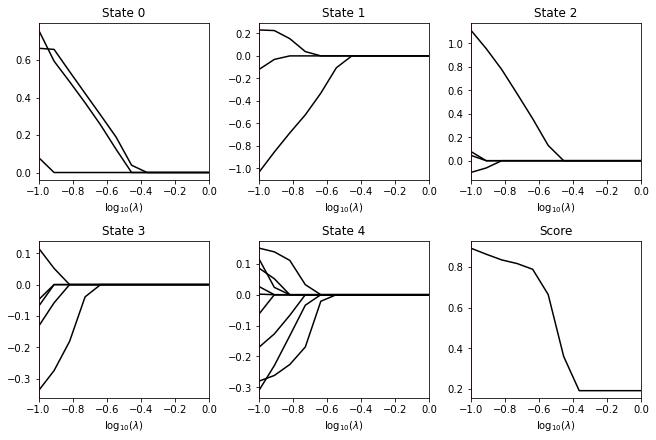

In [12]:
plot_cvpath(pruned_classifier, reg);

In [13]:
extrapruned_classifier = pruned_classifier.get_pruned(reg)
extrapruned_classifier.compute(regularizers, max_iter= 10000, quadratic_kernel=True)

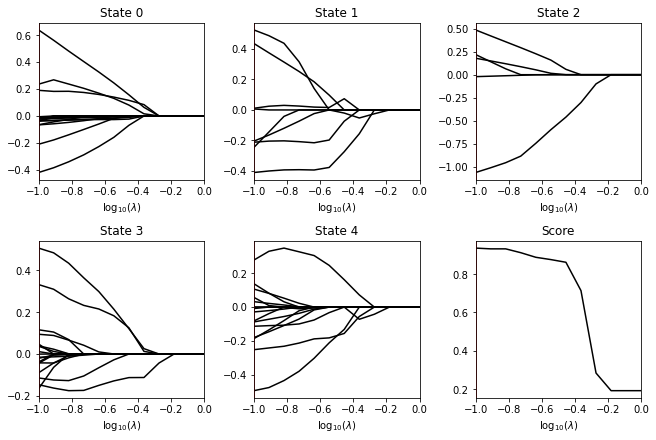

In [14]:
plot_cvpath(extrapruned_classifier, reg);

In [15]:
reg = 10**(-0.5)
extrapruned_classifier.print_selected(reg)

State 0:
	 48.761% | BACKBONE sin_phi CYS38
	 20.359% | BACKBONE sin_phi GLY36 || BACKBONE cos_psi GLY36
	 15.9%   | BACKBONE cos_psi ARG39
	 13.827% | BACKBONE cos_phi ARG39 || BACKBONE cos_psi ARG42
	 0.583%  | BACKBONE cos_psi PRO9 || BACKBONE cos_psi PRO9
	 0.256%  | BACKBONE cos_psi TYR35 || BACKBONE cos_psi TYR35
	 0.235%  | BACKBONE cos_phi CYS14 || BACKBONE cos_phi CYS14
	 0.048%  | BACKBONE cos_psi TYR35 || BACKBONE sin_psi TYR35
	 0.028%  | BACKBONE sin_phi CYS14 || BACKBONE sin_phi CYS14
	 0.003%  | BACKBONE sin_phi TYR35 || BACKBONE sin_phi TYR35
State 1:
	 74.502% | BACKBONE sin_phi GLY36 || BACKBONE cos_psi GLY36
	 20.388% | BACKBONE cos_phi ARG39
	 4.973%  | BACKBONE sin_phi CYS38 || BACKBONE sin_phi ARG42
	 0.136%  | BACKBONE sin_phi ARG42 || BACKBONE cos_psi ARG39
State 2:
	 93.356% | BACKBONE cos_psi LEU6 || BACKBONE cos_psi ARG42
	 6.584%  | BACKBONE cos_psi PRO9
	 0.06%   | BACKBONE cos_psi TYR10 || BACKBONE cos_psi TYR10
State 3:
	 47.517% | BACKBONE cos_psi PRO9 |

In [ ]:
plot_combination_cvs_relevant_features(df, cv_list, extrapruned_classifier._get_selected(reg))

Error: Session cannot generate requests